# TP 6  

### import libraries 

In [13]:
import numpy                as np
import pandas               as pd
import matplotlib.pyplot    as plt
from   scipy                import stats  
from   scipy.stats          import kstest,chisquare,expon,norm,expon,laplace
from  statsmodels.graphics.tsaplots import plot_acf
plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')

### Model Algorithm 

In [14]:
def get_bid_ask_prices(X):
    Pb = 0
    Pa = len(X)
    for i in range(len(X)):
        if X[i] < 0:
            Pb = i
        elif X[i] > 0:
            if Pa > i:
                Pa = i
    return Pb, Pa

def define_active_window(X,Pa,Pb,K):
    B = Pa + np.arange(-K,0)
    A = Pb + np.arange(1,K+1)
    A = X[A] 
    B = X[B]
    return A,B

def set_intensity_vector(mu,lamda,K,theta,A,B):
    Lamda = np.array([mu,mu,K*lamda,K*lamda,theta*np.linalg.norm(A, ord=1),theta*np.linalg.norm(B, ord=1)])
    return(Lamda)

def generate_time_interval(Lamda):
    return np.random.exponential(scale=1/np.linalg.norm(Lamda, ord=1))

def choose_next_action(Lamda):
    return np.random.choice(len(Lamda), p=Lamda/np.sum(Lamda))

def add_state_to_LOB(LOB_df,t,Pa,Pb,A,B,K):
    L = [t]
    for k in range(K):
        L += [Pa-k-1,-B[-k-1],Pb+k+1,A[k]]
    LOB_df.loc[len(LOB_df.index)] = L

def add_best_quotes(best_quotes_df,t,Pa,Pb,X):
    L = [t,Pb,X[Pb],Pa,X[Pa]]
    best_quotes_df.loc[len(best_quotes_df.index)] = L
    
def integrate_piecewise_constant_function(dataframe, T):
    data_array = dataframe.values
    
    x_values = data_array[:, 0]
    fx_values = data_array[:, 1]
    
    integral_value = 0
    for i in range(len(x_values) - 1):
        x_i = x_values[i]
        x_next = x_values[i + 1]
        

        f_i = fx_values[i]
        

        segment_integral = f_i * (min(x_next, T) - x_i)

        integral_value += segment_integral
        
        if x_next >= T:
            break
    
    return integral_value

def get_differences(lst):
    differences = []
    for i in range(len(lst) - 1):
        differences.append(lst[i+1] - lst[i])
    return np.array(differences)

def perform_ks_test(sample):
    ks_statistic, p_value = kstest(sample, expon.cdf)

    return ks_statistic, p_value


In [15]:
N = 1000
K = 10
mu = 2.5
lamda = 1
theta = 0.2
X0 = np.concatenate((-5*np.ones(N//2),5*np.ones(N//2)))
T = 1e4 
Bid_volums = ['ts','bq1','bq2','bq3','bq4','bq5','bq6','bq7','bq8','bq9','bq10']
Ask_volums = ['ts','aq1','aq2','aq3','aq4','aq5','aq6','aq7', 'aq8','aq9','aq10']

In [16]:
## Simulation
t = 0
iteration = 0
X = X0.copy()
Pb,Pa = get_bid_ask_prices(X)
P0 = np.random.choice([Pb,Pa])
Orders_df = pd.DataFrame(columns=['ts','type','side','level','price']) 
LOB_columns = ['ts'] 
for k in range(1,K+1):
    LOB_columns += [f'bp{k}', f'bq{k}', f'ap{k}', f'aq{k}']
LOB_df = pd.DataFrame(columns=LOB_columns)
best_quotes_columns = ['ts', 'bp1', 'bq1', 'ap1', 'aq1']
best_quotes_df = pd.DataFrame(columns=best_quotes_columns)

while t<T and iteration<1e4:
    if iteration%10000  ==  10000-1:
        print(f'Iteration {iteration+1} ..')
    #Initialization
    Pb,Pa = get_bid_ask_prices(X)
    assert Pa > Pb, print(f"Bid > Ask {iteration+1}")
    A ,B  = define_active_window(X,Pa,Pb,K)
    assert np.min(A)>=0, print(f"Ask side contains negative values {iteration+1}")
    assert np.max(B)<=0, print(f"Bid side contains positive values {iteration+1}")
    Lamda = set_intensity_vector(mu,lamda,K,theta,A,B)
    delta = generate_time_interval(Lamda)
    add_state_to_LOB(LOB_df,t,Pa,Pb,A,B,K)
    add_best_quotes(best_quotes_df,t,Pa,Pb,X)
    #Update step
    i = choose_next_action(Lamda)
    # Bid Market Order
    if i==0:
        X[Pb] += 1
        P0 = Pb
        df2 = {'ts':[t+delta],'type':['Market Order'],'side':['Bid'],'level':[0]}      
    # Ask Market Order
    elif i ==1:
        X[Pa] -= 1
        P0 = Pa
        df2 = {'ts':[t+delta],'type':['Market Order'],'side':['Ask'],'level':[0]}  
    # Bid Limit Order
    elif i==2:
        index = 1 + np.random.choice(K)
        X[Pa - index] -= 1
        df2 = {'ts':[t+delta],'type':['Limit Order'],'side':['Bid'],'level':[index]}
    # Ask Limit Order
    elif i==3:
        index = 1+np.random.choice(K)
        X[Pb+index] += 1
        df2 = {'ts':[t+delta],'type':['Limit Order'],'side':['Ask'],'level':[index]}
    # Bid Cancellation
    elif i==5:
        p = B/np.sum(B)
        index = np.random.choice(K,p=p)
        X[Pa -K + index] += 1
        df2 = {'ts':[t+delta],'type':['Cancellation'],'side':['Bid'],'level':[K-index]}
    # Ask Cancellation
    elif i==4:
        p = A/np.sum(A)
        index = 1+np.random.choice(K,p=p)
        X[Pb+index] -= 1
        df2 = {'ts':[t+delta],'type':['Cancellation'],'side':['Ask'],'level':[index]}
    df2['price']=[P0]
    df2 = pd.DataFrame(df2) 
    Orders_df = pd.concat([Orders_df, df2], ignore_index = True)     
    t += delta
    iteration += 1


Iteration 10000 ..


In [17]:
LOB_df.tail(5)

,ts,bp1,bq1,ap1,aq1,bp2,bq2,ap2,aq2,bp3,...,ap8,aq8,bp9,bq9,ap9,aq9,bp10,bq10,ap10,aq10
9995,251.684334,495.0,3.0,496.0,1.0,494.0,2.0,497.0,2.0,493.0,...,503.0,5.0,487.0,4.0,504.0,9.0,486.0,6.0,505.0,6.0
9996,251.736902,495.0,3.0,496.0,1.0,494.0,2.0,497.0,2.0,493.0,...,503.0,4.0,487.0,4.0,504.0,9.0,486.0,6.0,505.0,6.0
9997,251.744480,495.0,3.0,496.0,1.0,494.0,2.0,497.0,2.0,493.0,...,503.0,4.0,487.0,4.0,504.0,9.0,486.0,6.0,505.0,6.0
9998,251.745130,495.0,3.0,496.0,1.0,494.0,2.0,497.0,2.0,493.0,...,503.0,4.0,487.0,3.0,504.0,9.0,486.0,6.0,505.0,6.0
9999,251.746191,495.0,2.0,496.0,1.0,494.0,2.0,497.0,2.0,493.0,...,503.0,4.0,487.0,3.0,504.0,9.0,486.0,6.0,505.0,6.0


In [18]:
Orders_df.groupby(['type','side']).agg(ts = ('ts','count'))

ts
type         side      
Cancellation Ask   1857
             Bid   1903
Limit Order  Ask   2469
             Bid   2522
Market Order Ask    592
             Bid    657

In [19]:
# Orders_df.groupby(['type','side','level']).agg(ts = ('ts','count'))

#### 1. Sanity Check

- Print a small extract of the csv output of the simulation to illustrate that the orders are correctly processed. 
- Check that the number of bid and ask market and limit orders in the simulation is correct *(in agreement with the intensity parameters)* and
that the placement of limit orders in the simulation is correct *(uniform distribution)*.


##### a. Market Order

In [20]:
jump_time = Orders_df[(Orders_df['type']=='Market Order') & (Orders_df['side']=='Ask')]['ts'].values
duration  = get_differences(jump_time) 

ks_statistic, p_value = perform_ks_test(mu*duration)

print("Kolmogorov-Smirnov Test:")
print("KS Statistic:", f'{ks_statistic:.4f}')
print("p-value:", f'{p_value:.2%}')
if p_value < 0.05:
    print("Reject null hypothesis: Sample does not follow an exponential distribution")
else:
    print("Fail to reject null hypothesis: Sample follows an exponential distribution")

Kolmogorov-Smirnov Test:
KS Statistic: 0.0259
p-value: 81.40%
Fail to reject null hypothesis: Sample follows an exponential distribution


In [21]:
jump_time = Orders_df[(Orders_df['type']=='Market Order') & (Orders_df['side']=='Bid')]['ts'].values
duration  = get_differences(jump_time) 

ks_statistic, p_value = perform_ks_test(mu*duration)

print("Kolmogorov-Smirnov Test:")
print("KS Statistic:", f'{ks_statistic:.4f}')
print("p-value:", f'{p_value:.2%}')
if p_value < 0.05:
    print("Reject null hypothesis: Sample does not follow an exponential distribution")
else:
    print("Fail to reject null hypothesis: Sample follows an exponential distribution")

Kolmogorov-Smirnov Test:
KS Statistic: 0.0274
p-value: 69.80%
Fail to reject null hypothesis: Sample follows an exponential distribution


##### b. Limit Order

**Bid**

In [22]:
jump_time = Orders_df[(Orders_df['type']=='Limit Order') & (Orders_df['side']=='Bid') & (Orders_df['level']==1)]['ts'].values
duration  = get_differences(jump_time) 

ks_statistic, p_value = perform_ks_test(duration*lamda)

print("Kolmogorov-Smirnov Test:")
print("KS Statistic:", f'{ks_statistic:.4f}')
print("p-value:", f'{p_value:.2%}')
if p_value < 0.05:
    print("Reject null hypothesis: Sample does not follow an exponential distribution")
else:
    print("Fail to reject null hypothesis: Sample follows an exponential distribution")

Kolmogorov-Smirnov Test:
KS Statistic: 0.0742
p-value: 8.42%
Fail to reject null hypothesis: Sample follows an exponential distribution


In [23]:
jump_time = Orders_df[(Orders_df['type']=='Limit Order') & (Orders_df['side']=='Bid')]['ts'].values
duration  = get_differences(jump_time) 

ks_statistic, p_value = perform_ks_test(duration*lamda*K)

print("Kolmogorov-Smirnov Test:")
print("KS Statistic:", f'{ks_statistic:.4f}')
print("p-value:", f'{p_value:.2%}')
if p_value < 0.05:
    print("Reject null hypothesis: Sample does not follow an exponential distribution")
else:
    print("Fail to reject null hypothesis: Sample follows an exponential distribution")

Kolmogorov-Smirnov Test:
KS Statistic: 0.0170
p-value: 45.59%
Fail to reject null hypothesis: Sample follows an exponential distribution


In [24]:
placement = Orders_df[(Orders_df['type']=='Limit Order') & (Orders_df['side']=='Bid')]['level'].values

unique_values, observed = np.unique(placement, return_counts=True)
observed = observed/np.sum(observed)
expected = np.full_like(observed, fill_value=1/K)

chi_squared_statistic, p_value = chisquare(observed, expected)
print("Chi-square Test:")
print("Chi-squared Statistic:",  f'{chi_squared_statistic:.4f}')
print("p-value:", f'{p_value:.2%}')
if p_value > 0.05:
    print("Fail to reject null hypothesis: Data follows a uniform distribution")
else:
    print("Reject null hypothesis: Data does not follow a uniform distribution")


Chi-square Test:
Chi-squared Statistic: 0.0064
p-value: 100.00%
Fail to reject null hypothesis: Data follows a uniform distribution


**Ask**

In [25]:
jump_time = Orders_df[(Orders_df['type']=='Limit Order') & (Orders_df['side']=='Ask')]['ts'].values
duration  = get_differences(jump_time) 

ks_statistic, p_value = perform_ks_test(duration*lamda*K)

print("Kolmogorov-Smirnov Test:")
print("KS Statistic:", f'{ks_statistic:.4f}')
print("p-value:", f'{p_value:.2%}')
if p_value < 0.05:
    print("Reject null hypothesis: Sample does not follow an exponential distribution")
else:
    print("Fail to reject null hypothesis: Sample follows an exponential distribution")

Kolmogorov-Smirnov Test:
KS Statistic: 0.0205
p-value: 24.81%
Fail to reject null hypothesis: Sample follows an exponential distribution


In [26]:
placement = Orders_df[(Orders_df['type']=='Limit Order') & (Orders_df['side']=='Ask')]['level'].values

unique_values, observed = np.unique(placement, return_counts=True)
observed = observed/np.sum(observed)
expected = np.full_like(observed, fill_value=1/K)

chi_squared_statistic, p_value = chisquare(observed, expected)
print("Chi-square Test:")
print("Chi-squared Statistic:",  f'{chi_squared_statistic:.4f}')
print("p-value:", f'{p_value:.2%}')
if p_value > 0.05:
    print("Fail to reject null hypothesis: Data follows a uniform distribution")
else:
    print("Reject null hypothesis: Data does not follow a uniform distribution")


Chi-square Test:
Chi-squared Statistic: 0.0020
p-value: 100.00%
Fail to reject null hypothesis: Data follows a uniform distribution


##### C. cancellation

$(\Lambda(S_i)-\Lambda(S_{i-1}) = \int_{S_{i-1}}^{S_i} \lambda(t) \,dt)_{i \in [[1,n]]}$ should has an exponential distribition for parameter $\lambda=1$, so that the time change theorem is respected.

In [27]:
Bid_volume_df = LOB_df[Bid_volums].copy()
Bid_volume_df['liquidity'] =  Bid_volume_df[Bid_volums[1:]].sum(axis=1)
Bid_volume_df['intesity'] = Bid_volume_df['liquidity']*theta
intensity_df =  Bid_volume_df[['ts','intesity']].copy()

jump_time = Orders_df[(Orders_df['type']=='Cancellation') & (Orders_df['side']=='Bid')]['ts'].values

lamda_jump = np.array([integrate_piecewise_constant_function(intensity_df, s) for s in jump_time])
lamda_simulated_duration = get_differences(lamda_jump)

sample = 1*lamda_simulated_duration
ks_statistic, p_value = perform_ks_test(sample)

print("Kolmogorov-Smirnov Test:")
print("KS Statistic:", f'{ks_statistic:.4f}')
print("p-value:", f'{p_value:.2%}')
if p_value < 0.05:
    print("Reject null hypothesis: Sample does not follow an exponential distribution")
else:
    print("Fail to reject null hypothesis: Sample follows an exponential distribution")

Kolmogorov-Smirnov Test:
KS Statistic: 0.0143
p-value: 82.54%
Fail to reject null hypothesis: Sample follows an exponential distribution


In [28]:
Ask_volume_df = LOB_df[Ask_volums].copy()
Ask_volume_df['liquidity'] =  Ask_volume_df[Ask_volums[1:]].sum(axis=1)
Ask_volume_df['intesity'] = Ask_volume_df['liquidity']*theta
intensity_df =  Ask_volume_df[['ts','intesity']].copy()

jump_time = Orders_df[(Orders_df['type']=='Cancellation') & (Orders_df['side']=='Ask')]['ts'].values

lamda_jump = np.array([integrate_piecewise_constant_function(intensity_df, s) for s in jump_time])
lamda_simulated_duration = get_differences(lamda_jump)

sample = 1*lamda_simulated_duration
ks_statistic, p_value = perform_ks_test(sample)

print("Kolmogorov-Smirnov Test:")
print("KS Statistic:", f'{ks_statistic:.4f}')
print("p-value:", f'{p_value:.2%}')
if p_value < 0.05:
    print("Reject null hypothesis: Sample does not follow an exponential distribution")
else:
    print("Fail to reject null hypothesis: Sample follows an exponential distribution")

Kolmogorov-Smirnov Test:
KS Statistic: 0.0204
p-value: 41.90%
Fail to reject null hypothesis: Sample follows an exponential distribution


#### 2. Main analysis

In [29]:
df_quotes = best_quotes_df[['ts', 'bp1', 'bq1', 'ap1', 'aq1']].copy()
df_quotes['ts'] = pd.to_datetime(df_quotes['ts'], unit='s')
df_quotes['spread'] = df_quotes['ap1']-df_quotes['bp1']
df_quotes['mid']    = 0.5*(df_quotes['bp1']+df_quotes['ap1'])
df_quotes['mid_weighted'] = (df_quotes['aq1']*df_quotes['bp1']+df_quotes['bq1']*df_quotes['ap1'])/(df_quotes['aq1']+df_quotes['bq1'])
df_quotes['imbalance'] = (df_quotes['bq1']-df_quotes['aq1'])/(df_quotes['aq1']+df_quotes['bq1'])

2.1 Plot the average shape of the simulated LOB. Compute an approximation of the value of the average shape away from the best bid and ask, using a queuing model. Are your simulationsin agreement with the analytical result ?

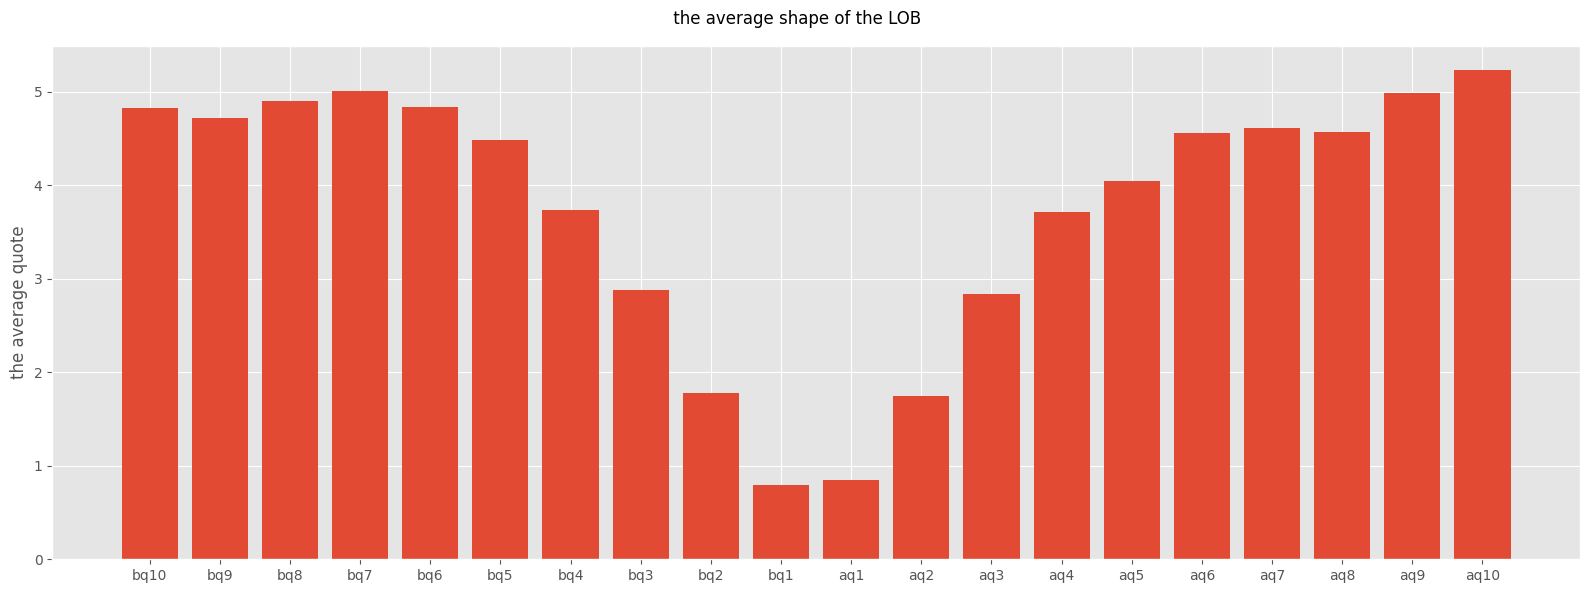

In [30]:
List_columns = ['bq10','bq9', 'bq8','bq7','bq6','bq5','bq4','bq3','bq2','bq1','aq1','aq2','aq3','aq4','aq5','aq6','aq7','aq8','aq9','aq10']


df = pd.DataFrame(LOB_df[List_columns].mean())

fig, ax = plt.subplots(figsize=(16,6))
fig.suptitle(r' the average shape of the LOB')

ax.bar(df.index, df.iloc[:, 0])
ax.set_ylabel(r'the average quote')

plt.tight_layout()
plt.show()

The shape has certain similarity but it does not capture the whole complexity of the real LOB. We see that  

2.2 Plot the spread distribution.

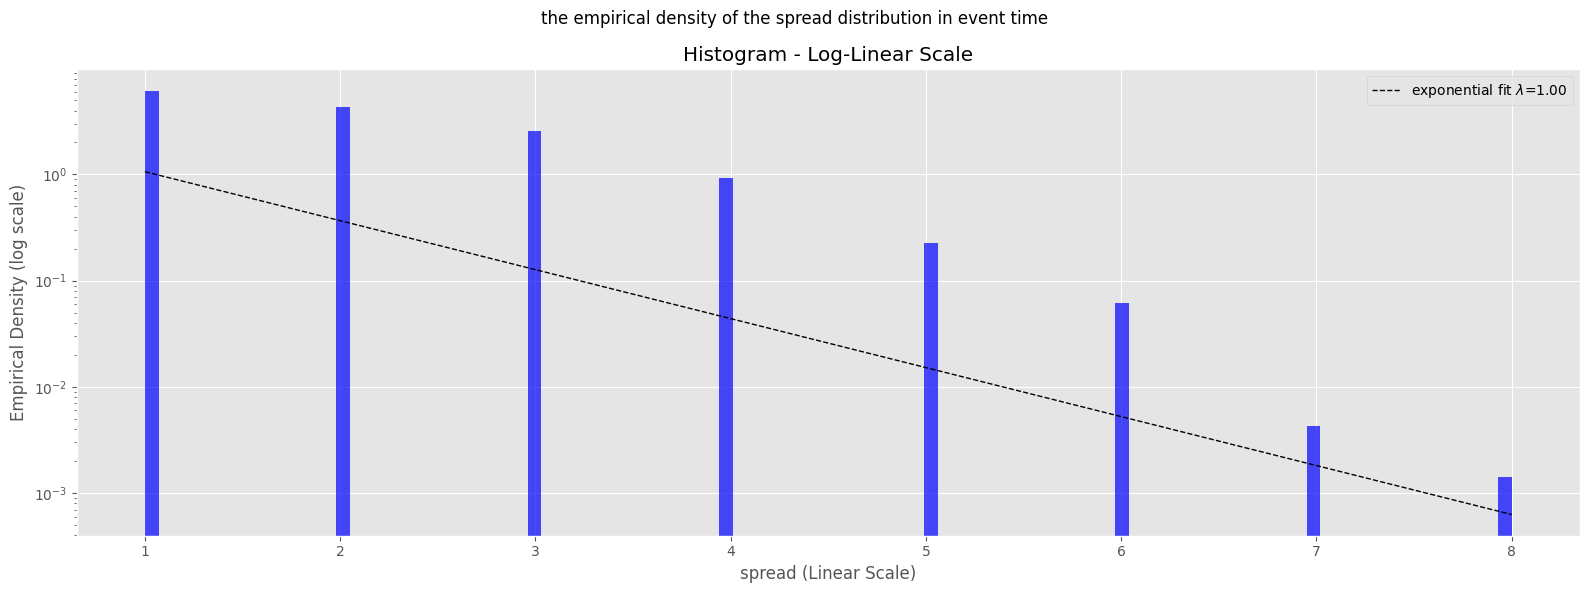

In [31]:
spread = df_quotes['spread'].values
fig, ax = plt.subplots(figsize=(16,6))
fig.suptitle(r'the empirical density of the spread distribution in event time')

params= expon.fit(spread)
xmin, xmax = np.min(spread), np.max(spread)
x = np.linspace(xmin, xmax, 100)
p = expon.pdf(x, *params)

ax.hist(spread, bins=100, density=True, log=True, color='blue', alpha=0.7)
ax.plot(x, p, linewidth=1,color='black',label=r'exponential fit $\lambda$='+f'{1/params[0]:.2f}',linestyle='--')
#ax.set_xscale('log')
ax.set_title('Histogram - Log-Linear Scale')
ax.set_xlabel('spread (Linear Scale)')
ax.set_ylabel('Empirical Density (log scale)')
ax.legend()

plt.tight_layout()
plt.show()

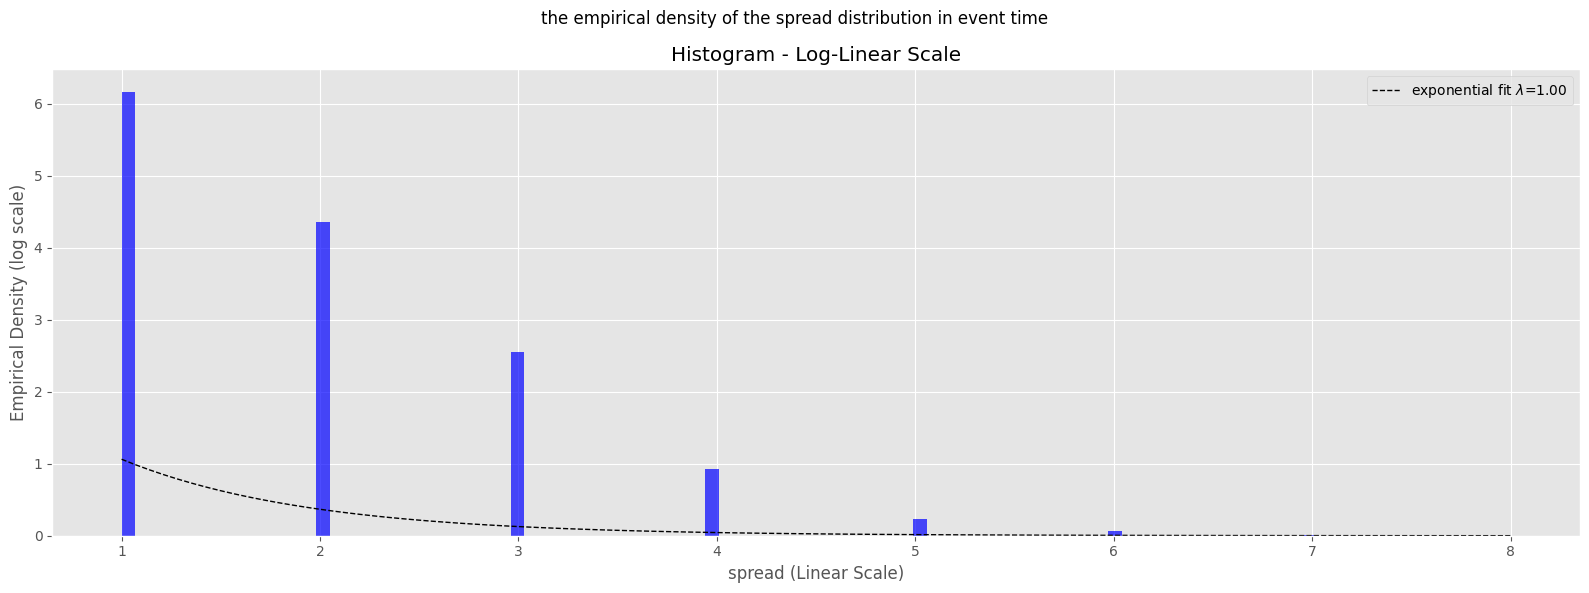

In [32]:
spread = df_quotes['spread'].values
fig, ax = plt.subplots(figsize=(16,6))
fig.suptitle(r'the empirical density of the spread distribution in event time')

params= expon.fit(spread)
xmin, xmax = np.min(spread), np.max(spread)
x = np.linspace(xmin, xmax, 100)
p = expon.pdf(x, *params)

ax.hist(spread, bins=100, density=True, color='blue', alpha=0.7)
ax.plot(x, p, linewidth=1,color='black',label=r'exponential fit $\lambda$='+f'{1/params[0]:.2f}',linestyle='--')
#ax.set_xscale('log')
ax.set_title('Histogram - Log-Linear Scale')
ax.set_xlabel('spread (Linear Scale)')
ax.set_ylabel('Empirical Density (log scale)')
ax.legend()

plt.tight_layout()
plt.show()

2.3 Plot the mid-price variation at a large time scale.

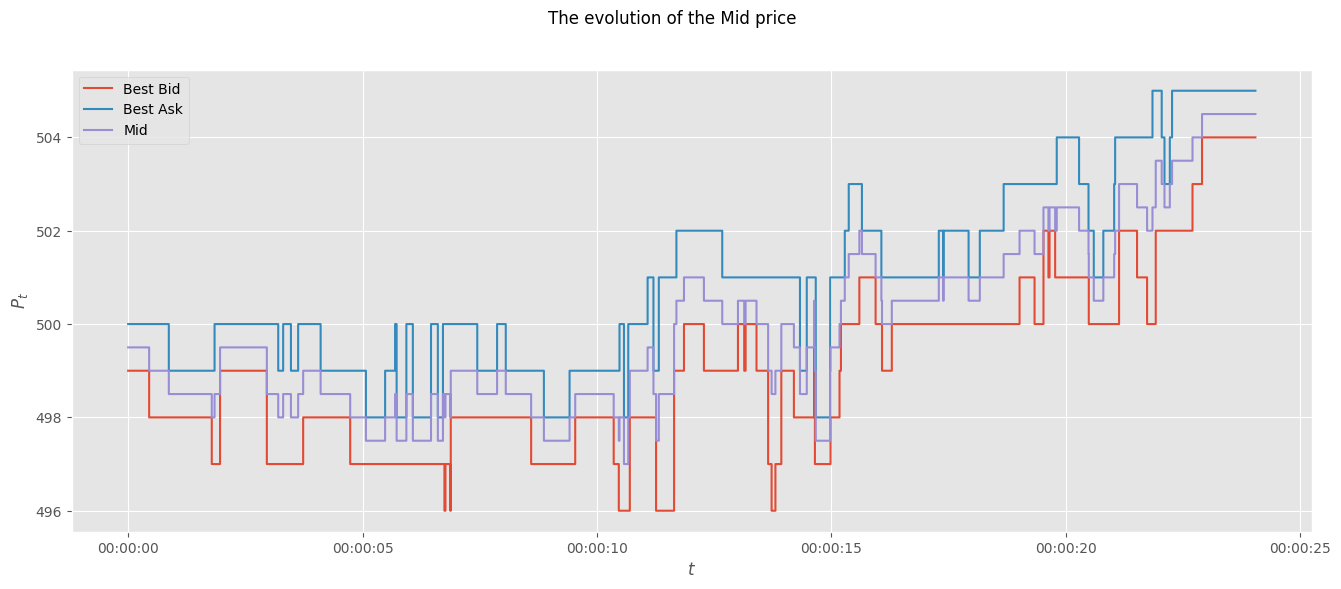

In [33]:
stop = 1000
fig, ax = plt.subplots(figsize=(16,6))
fig.suptitle(r'The evolution of the Mid price')

ax.step(df_quotes['ts'][:stop],df_quotes['bp1'][:stop],label=r'Best Bid')
ax.step(df_quotes['ts'][:stop],df_quotes['ap1'][:stop],label=r'Best Ask')
ax.step(df_quotes['ts'][:stop],df_quotes['mid'][:stop],label=r'Mid')
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$P_t$')

ax.legend()

plt.show()

2.4 Plot the distribution of mid-price increments for several sampling periods. 

In [34]:
df_sample = df_quotes[['ts','mid']].copy()
df_sample.set_index('ts', inplace=True)

resampled_1s = df_sample['mid'].resample('1s').last().diff().dropna()
normalized_1s = (resampled_1s - resampled_1s.mean()) / resampled_1s.std()
resampled_5s = df_sample['mid'].resample('5s').last().diff().dropna()
normalized_5s = (resampled_5s - resampled_5s.mean()) / resampled_5s.std()
resampled_500ms = df_sample['mid'].resample('0.5s').last().diff().dropna()
normalized_500ms = (resampled_500ms - resampled_500ms.mean()) / resampled_500ms.std()

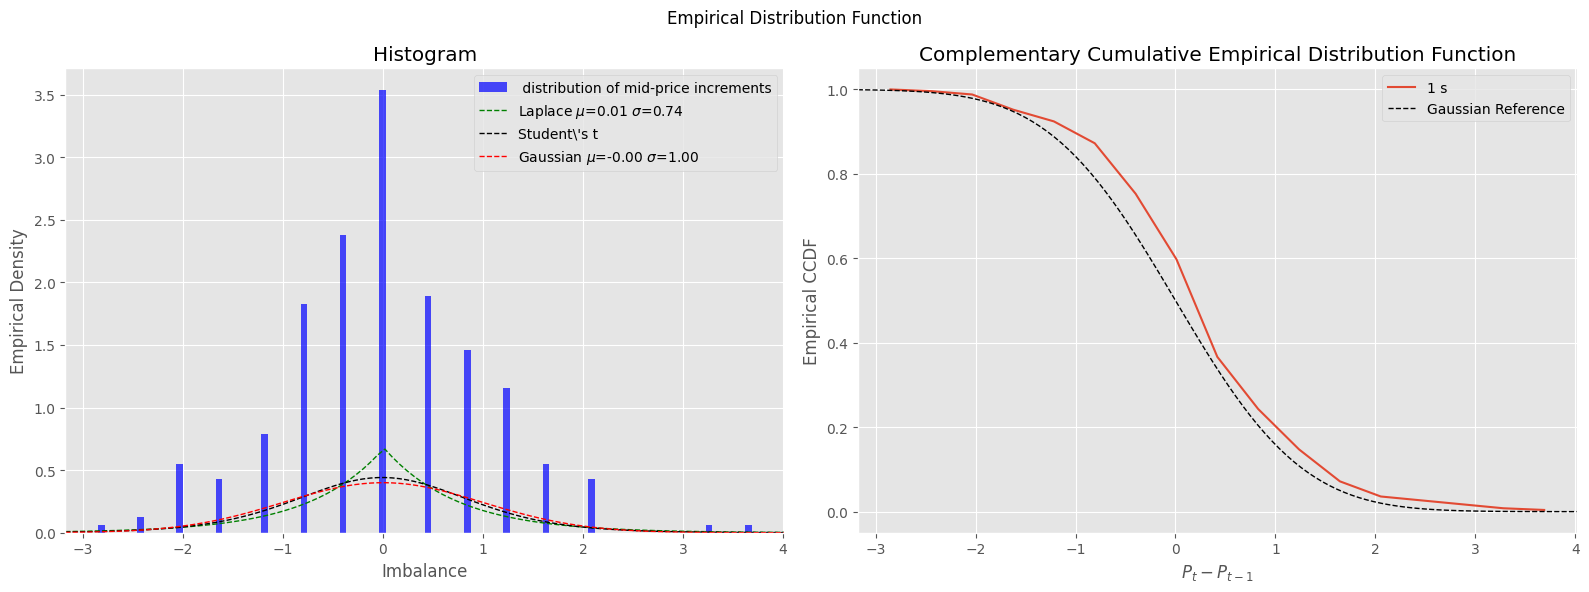

In [35]:
fig, ax = plt.subplots(1,2,figsize=(16,6))
fig.suptitle(r'Empirical Distribution Function')

# 1 s
ax[0].hist(normalized_1s, bins=100, density=True, color='blue', alpha=0.7,label=' distribution of mid-price increments')
xmin, xmax = ax[0].set_xlim()
x = np.linspace(xmin, xmax, 100)

# Fit Student's t-distribution
t_params = stats.t.fit(normalized_1s)
pdf_t = stats.t.pdf(x, *t_params)
# Fit Gaussian distribution
mu, sigma = norm.fit(normalized_1s)
pdf_norm = norm.pdf(x, mu, sigma)
# Fit Laplace distribution
loc, scale = laplace.fit(normalized_1s)
laplace_pdf = laplace.pdf(x, loc=loc, scale=scale)

ax[0].plot(x, laplace_pdf, 'g', linewidth=1,linestyle='--', label=r'Laplace $\mu$='+f'{loc:.2f}'+r' $\sigma$='+f'{scale:.2f}')
ax[0].plot(x, pdf_t      , 'k', linewidth=1,linestyle='--', label=r'Student\'s t')
ax[0].plot(x, pdf_norm   , 'r', linewidth=1,linestyle='--', label=r'Gaussian $\mu$='+f'{mu:.2f}'+r' $\sigma$='+f'{sigma:.2f}')
ax[0].set_title('Histogram')
ax[0].set_xlabel('Imbalance')
ax[0].set_ylabel('Empirical Density')
ax[0].legend()


sorted_data_1s = normalized_1s.sort_values(ascending=False)
ccdf_1s = sorted_data_1s.rank(ascending=False, method='max') / len(sorted_data_1s)
ax[1].plot(sorted_data_1s, ccdf_1s, label='1 s')

# Add Gaussian reference
xmin, xmax = ax[1].set_xlim()
x = np.linspace(xmin, xmax, 100)
mu, std = 0, 1
p = 1- norm.cdf(x, mu, std)
ax[1].plot(x, p, 'k', linewidth=1, linestyle='--', label='Gaussian Reference')
ax[1].set_title('Complementary Cumulative Empirical Distribution Function')
ax[1].legend()
ax[1].set_xlabel(r'$P_t-P_{t-1}$')
ax[1].set_ylabel('Empirical CCDF')

plt.tight_layout()
plt.show()

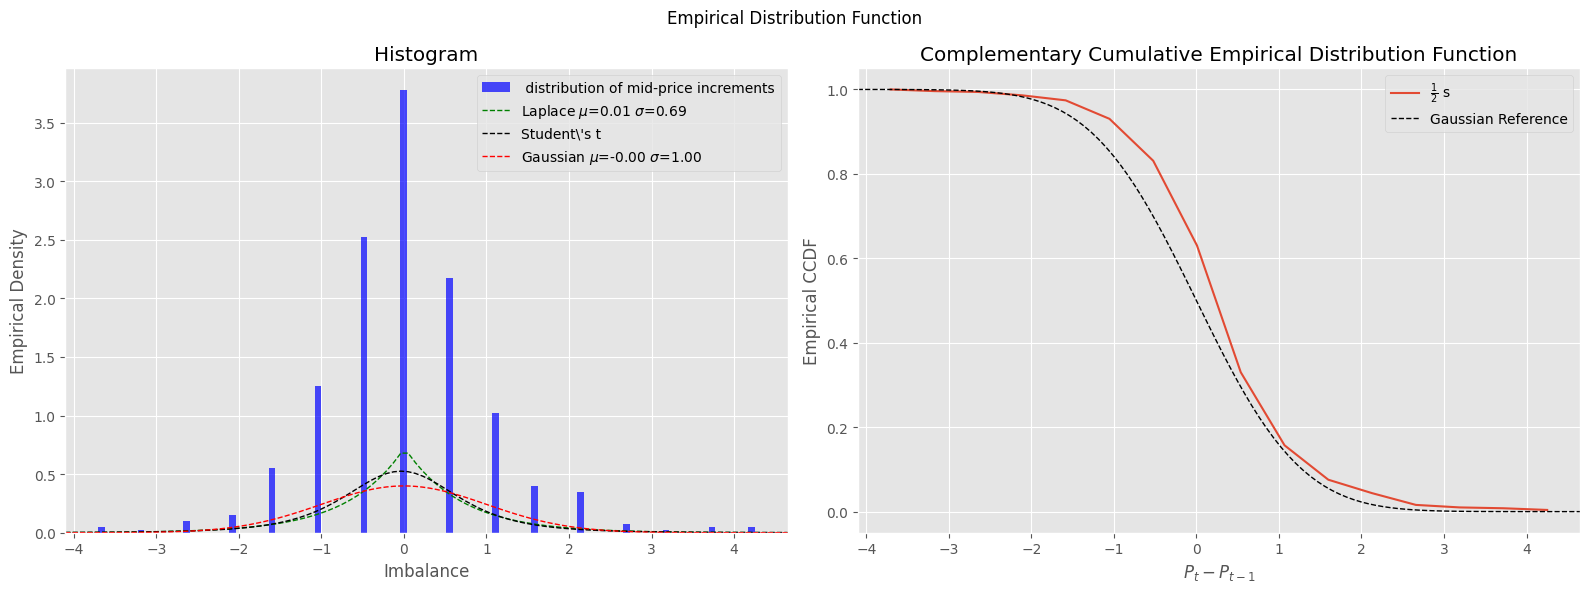

In [36]:
fig, ax = plt.subplots(1,2,figsize=(16,6))
fig.suptitle(r'Empirical Distribution Function')

# 1 s
ax[0].hist(normalized_500ms, bins=100, density=True, color='blue', alpha=0.7,label=' distribution of mid-price increments')
xmin, xmax = ax[0].set_xlim()
x = np.linspace(xmin, xmax, 100)

# Fit Student's t-distribution
t_params = stats.t.fit(normalized_500ms)
pdf_t = stats.t.pdf(x, *t_params)
# Fit Gaussian distribution
mu, sigma = norm.fit(normalized_500ms)
pdf_norm = norm.pdf(x, mu, sigma)
# Fit Laplace distribution
loc, scale = laplace.fit(normalized_500ms)
laplace_pdf = laplace.pdf(x, loc=loc, scale=scale)

ax[0].plot(x, laplace_pdf, 'g', linewidth=1,linestyle='--', label=r'Laplace $\mu$='+f'{loc:.2f}'+r' $\sigma$='+f'{scale:.2f}')
ax[0].plot(x, pdf_t      , 'k', linewidth=1,linestyle='--', label=r'Student\'s t')
ax[0].plot(x, pdf_norm   , 'r', linewidth=1,linestyle='--', label=r'Gaussian $\mu$='+f'{mu:.2f}'+r' $\sigma$='+f'{sigma:.2f}')
ax[0].set_title('Histogram')
ax[0].set_xlabel('Imbalance')
ax[0].set_ylabel('Empirical Density')
ax[0].legend()


sorted_data_1s = normalized_500ms.sort_values(ascending=False)
ccdf_1s = sorted_data_1s.rank(ascending=False, method='max') / len(sorted_data_1s)
ax[1].plot(sorted_data_1s, ccdf_1s, label=r'$\frac{1}{2}$ s')

# Add Gaussian reference
xmin, xmax = ax[1].set_xlim()
x = np.linspace(xmin, xmax, 100)
mu, std = 0, 1
p = 1- norm.cdf(x, mu, std)
ax[1].plot(x, p, 'k', linewidth=1, linestyle='--', label='Gaussian Reference')
ax[1].set_title('Complementary Cumulative Empirical Distribution Function')
ax[1].legend()
ax[1].set_xlabel(r'$P_t-P_{t-1}$')
ax[1].set_ylabel('Empirical CCDF')

plt.tight_layout()
plt.show()

Comment:

2.5 Plot the autocorrelation function of the increments of the mid-price and of the trade price.

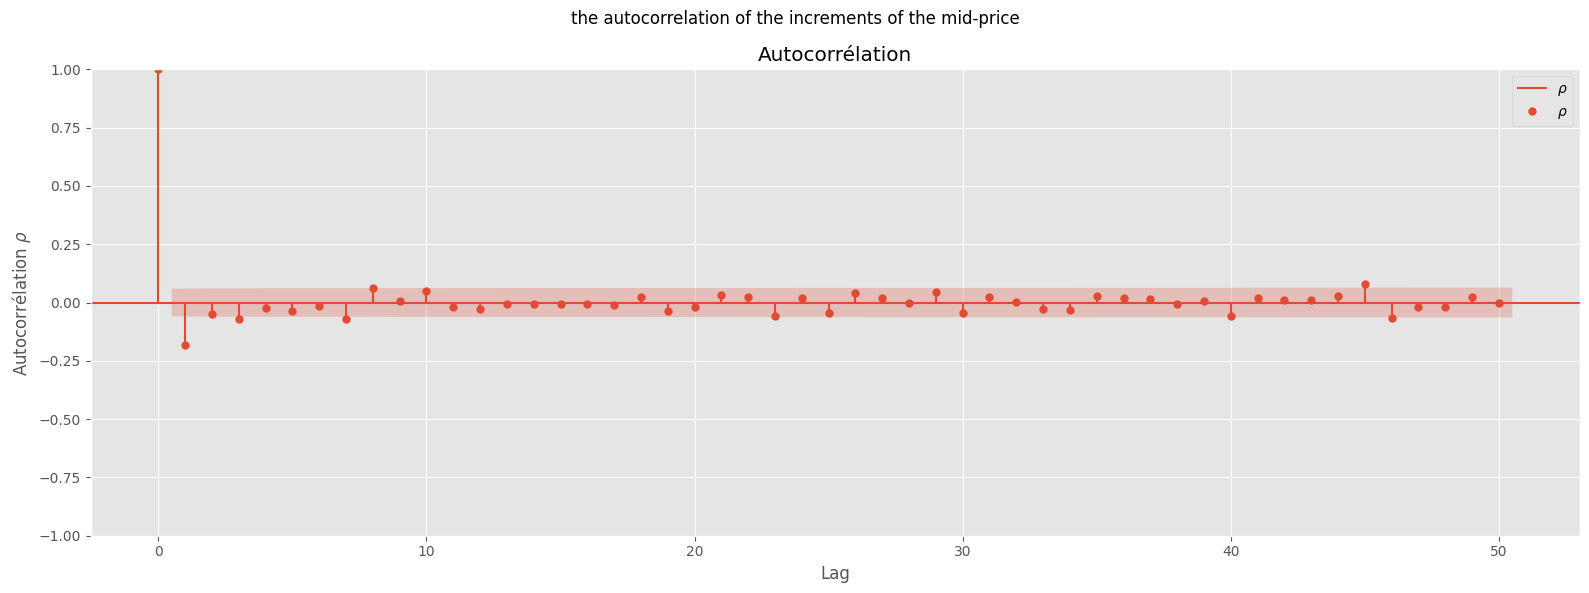

In [37]:
df_tick_test = df_quotes[['ts','mid']].copy()
df_tick_test.set_index('ts', inplace=True)
resampled = pd.DataFrame(df_tick_test['mid'].diff().dropna())

fig, ax = plt.subplots(figsize=(16,6))
fig.suptitle(r'the autocorrelation of the increments of the mid-price')

plot_acf(resampled[resampled['mid']!=0],ax=ax ,lags=50, alpha=0.05,label=r'$\rho$')
ax.set_title('Autocorrélation')
ax.set_xlabel('Lag')
ax.set_ylabel(r'Autocorrélation $\rho$')
ax.legend()

plt.tight_layout()
plt.show()

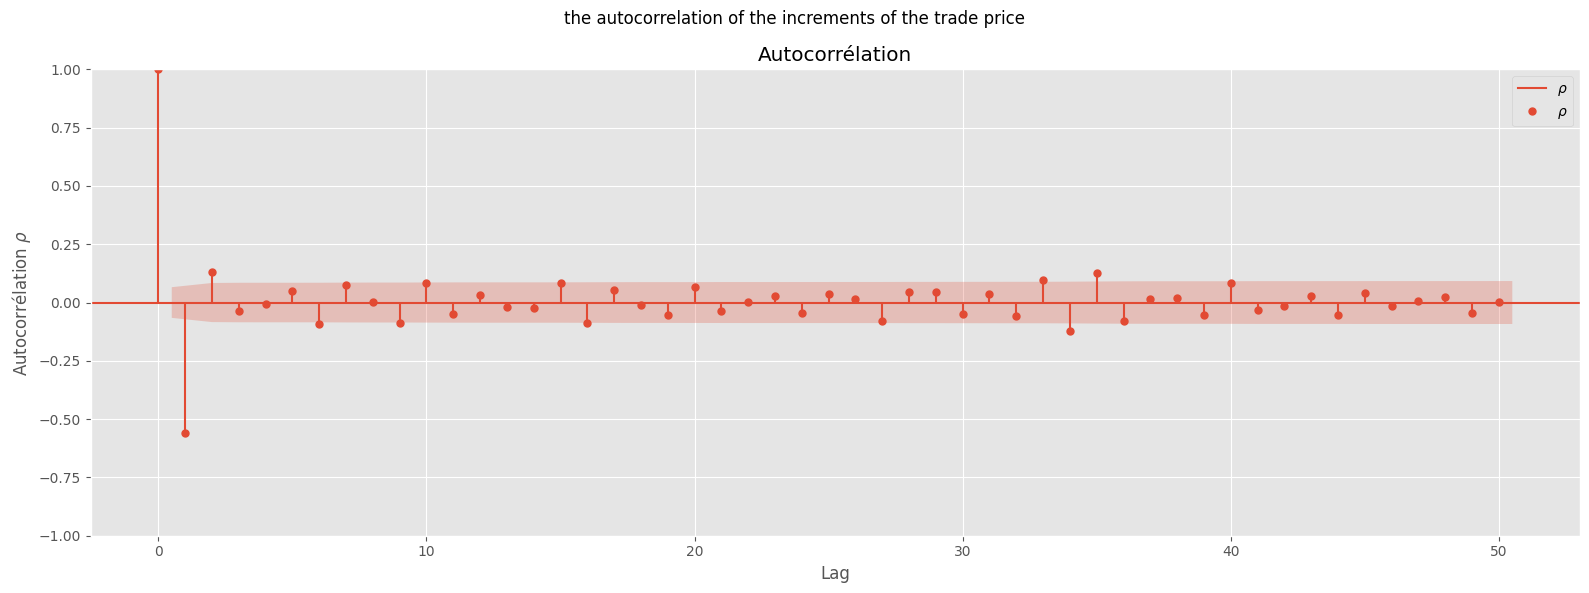

In [38]:
df_tick_test = Orders_df[['ts','price']].copy()
df_tick_test.set_index('ts', inplace=True)
resampled = pd.DataFrame(df_tick_test['price'].diff().dropna())

fig, ax = plt.subplots(figsize=(16,6))
fig.suptitle(r'the autocorrelation of the increments of the trade price')

plot_acf(resampled[resampled['price']!=0],ax=ax ,lags=50, alpha=0.05,label=r'$\rho$')
ax.set_title('Autocorrélation')
ax.set_xlabel('Lag')
ax.set_ylabel(r'Autocorrélation $\rho$')
ax.legend()

plt.tight_layout()
plt.show()

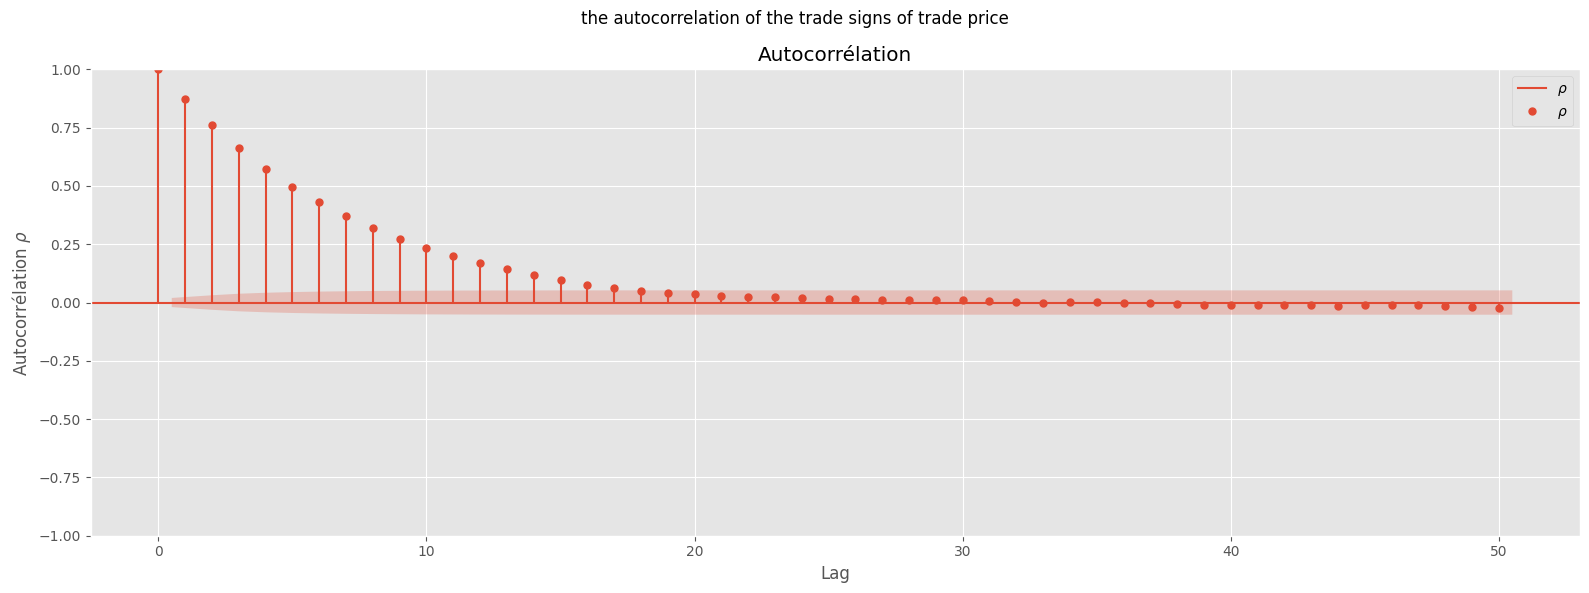

In [39]:
df_tick_test = Orders_df[['ts','price']].copy()
df_tick_test['tick test'] = 0

change_price = df_tick_test['price'].diff()
positive = change_price>0
negative = change_price<0
df_tick_test.loc[positive,'tick test'] = 1
df_tick_test.loc[negative,'tick test'] = -1
mask = (df_tick_test['tick test'] == 0)
df_tick_test.loc[mask, 'tick test'] = None
df_tick_test['tick test'] = df_tick_test['tick test'].ffill()
df_tick_test.dropna(inplace=True)

fig, ax = plt.subplots(figsize=(16,6))
fig.suptitle(r'the autocorrelation of the trade signs of trade price')

plot_acf(df_tick_test['tick test'],ax=ax ,lags=50, alpha=0.05,label=r'$\rho$')
ax.set_title('Autocorrélation')
ax.set_xlabel('Lag')
ax.set_ylabel(r'Autocorrélation $\rho$')
ax.legend()

plt.tight_layout()
plt.show()

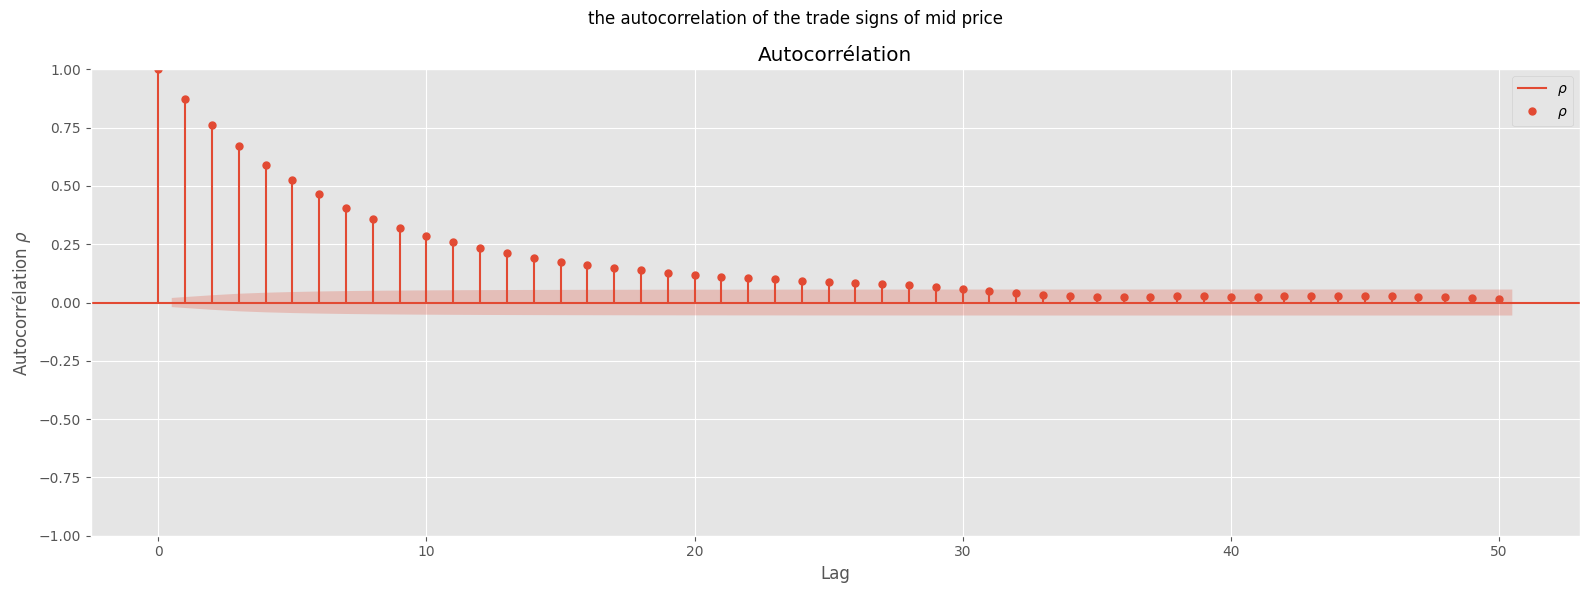

In [42]:
df_tick_test = df_quotes[['ts','mid']].copy()
df_tick_test['tick test'] = 0

change_price = df_tick_test['mid'].diff()
positive = change_price>0
negative = change_price<0
df_tick_test.loc[positive,'tick test'] = 1
df_tick_test.loc[negative,'tick test'] = -1
mask = (df_tick_test['tick test'] == 0)
df_tick_test.loc[mask, 'tick test'] = None
df_tick_test['tick test'] = df_tick_test['tick test'].ffill()
df_tick_test.dropna(inplace=True)

fig, ax = plt.subplots(figsize=(16,6))
fig.suptitle(r'the autocorrelation of the trade signs of mid price')

plot_acf(df_tick_test['tick test'],ax=ax ,lags=50, alpha=0.05,label=r'$\rho$')
ax.set_title('Autocorrélation')
ax.set_xlabel('Lag')
ax.set_ylabel(r'Autocorrélation $\rho$')
ax.legend()

plt.tight_layout()
plt.show()

In [41]:
unique_values, observed = np.unique(df_tick_test['tick test'].values, return_counts=True)
print(unique_values, observed)

[-1.  1.] [4996 4980]


Comment

#### 3.Optional

Modify your simulator so that it can use the calibrated values of the order intensities and the volume sizes of the simulator given in [1]. Can you reproduce the results ?